In [1]:
import carla
import pygame
import numpy as np
import os
import datetime
import time
import math

pygame 2.6.1 (SDL 2.28.4, Python 3.7.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Initialize pygame for keyboard control
pygame.init()
screen = pygame.display.set_mode((800, 600))
pygame.display.set_caption("CARLA Manual Control - Waypoint Collector")
font = pygame.font.SysFont("Arial", 18)

# Connect to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.get_world()

# Set up camera for visualization
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '800')
camera_bp.set_attribute('image_size_y', '600')
camera_bp.set_attribute('fov', '90')  # Wider field of view

# Choose a vehicle blueprint
vehicle_bp = world.get_blueprint_library().filter('model3')[0]  # Using Tesla Model 3

# Get a spawn point
spawn_points = world.get_map().get_spawn_points()
spawn_point = spawn_points[0]  # Choose the first spawn point

# Spawn the vehicle
vehicle = world.try_spawn_actor(vehicle_bp, spawn_point)
if vehicle is None:
    print("Failed to spawn vehicle. Trying a different location...")
    for sp in spawn_points[1:]:
        vehicle = world.try_spawn_actor(vehicle_bp, sp)
        if vehicle is not None:
            break

if vehicle is None:
    raise Exception("Could not spawn vehicle")

print(f"Vehicle spawned at: {vehicle.get_location()}")

# Spawn a camera attached to the vehicle - positioned higher up for better visibility
camera_transform = carla.Transform(carla.Location(x=0.5, z=3.0))  # Raised camera position
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

# Setup camera for visualization
camera_data = {'surface': None}

def camera_callback(image):
    """Convert image from camera to a pygame surface."""
    try:
        # Convert CARLA raw image to numpy array
        image.convert(carla.ColorConverter.Raw)
        array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        array = np.reshape(array, (image.height, image.width, 4))
        array = array[:, :, :3]  # Remove alpha channel
        array = array[:, :, ::-1]  # Convert BGR to RGB
        
        # Create pygame surface
        surface = pygame.surfarray.make_surface(array.swapaxes(0, 1))
        camera_data['surface'] = surface
    except Exception as e:
        print(f"Error in camera callback: {e}")

camera.listen(camera_callback)

# Wait a moment for the camera to start capturing
print("Waiting for camera to initialize...")
time.sleep(1)

# Setup for waypoint collection
waypoints = []

def save_waypoints(waypoints, filename=None):
    """Save waypoints to a file."""
    if not filename:
        # Create filename with timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        filename = f"waypoints_{timestamp}.txt"
    
    with open(filename, 'w') as f:
        f.write("x,y,z,yaw\n")  # Header
        for wp in waypoints:
            loc = wp['location']
            f.write(f"{loc.x},{loc.y},{loc.z},{wp['yaw']}\n")
    
    print(f"Waypoints saved to {filename}")
    return filename

# Main control loop
clock = pygame.time.Clock()
running = True
recording = False
throttle = 0.0
steering = 0.0
brake = 0.0
recording_interval = 0.5  # seconds between waypoint captures
last_recorded_time = time.time()

# Target speed limit when recording (in km/h)
MAX_SPEED = 30.0

print("Controls:")
print("W/S: Throttle/Brake")
print("A/D: Steering")
print("R: Start/Stop recording")
print("ESC: Quit")

while running:
    # Process input
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
            elif event.key == pygame.K_r:
                recording = not recording
                if recording:
                    print("Recording started...")
                    waypoints = []  # Clear previous waypoints
                else:
                    print("Recording stopped.")
                    if waypoints:
                        save_waypoints(waypoints)
    
    # Get current speed in km/h
    velocity = vehicle.get_velocity()
    current_speed = 3.6 * math.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)  # m/s to km/h
    
    # Handle continuous key press for vehicle control
    keys = pygame.key.get_pressed()
    
    # Throttle control with speed limiting
    if keys[pygame.K_w]:
        # If speed is approaching the limit, reduce throttle application rate
        if current_speed >= MAX_SPEED * 0.8:
            throttle_increment = 0.005  # Gentler acceleration near limit
        else:
            throttle_increment = 0.01   # Normal acceleration
            
        # If we're over the speed limit, release throttle
        if current_speed >= MAX_SPEED:
            throttle = max(0.0, throttle - 0.03)  # Gradually reduce throttle
        else:
            throttle = min(0.5, throttle + throttle_increment)  # Limited max throttle for better control
        
        brake = 0.0
    elif keys[pygame.K_s]:
        brake = min(1.0, brake + 0.05)
        throttle = 0.0
    else:
        throttle = max(0.0, throttle - 0.05)
        brake = max(0.0, brake - 0.05)
    
    if keys[pygame.K_a]:
        steering = max(-1.0, steering - 0.05)
    elif keys[pygame.K_d]:
        steering = min(1.0, steering + 0.05)
    else:
        steering = steering * 0.9  # Gradual return to straight

    # Apply control to the vehicle
    vehicle.apply_control(carla.VehicleControl(
        throttle=throttle,
        steer=steering,
        brake=brake
    ))
    
    # Record waypoint if recording is enabled
    if recording and time.time() - last_recorded_time >= recording_interval:
        transform = vehicle.get_transform()
        waypoint = {
            'location': transform.location,
            'yaw': transform.rotation.yaw
        }
        waypoints.append(waypoint)
        print(f"Recorded waypoint: {transform.location}")
        last_recorded_time = time.time()
    
    # Clear the screen
    screen.fill((0, 0, 0))  # Fill with black
    
    # Display camera image
    if camera_data['surface'] is not None:
        screen.blit(camera_data['surface'], (0, 0))
    else:
        # If no camera image is available, show a message
        no_camera_text = font.render("Waiting for camera...", True, (255, 255, 255))
        screen.blit(no_camera_text, (400 - no_camera_text.get_width()//2, 300 - no_camera_text.get_height()//2))
        
    # Display status text
    status_text = f"Throttle: {throttle:.2f} | Steering: {steering:.2f} | Brake: {brake:.2f}"
    
    # Determine color for speed display based on current speed
    if current_speed > MAX_SPEED:
        speed_color = (255, 0, 0)  # Red if over speed limit
        speed_text = f"Speed: {current_speed:.1f} km/h (TOO FAST!)"
    else:
        speed_text = f"Speed: {current_speed:.1f} km/h"
        # Gradient from green to yellow as speed increases
        green = max(0, int(255 * (1 - current_speed / MAX_SPEED)))
        speed_color = (255 - green, green, 0)
    
    record_status = "RECORDING" if recording else "NOT RECORDING"
    waypoints_count = len(waypoints) if waypoints else 0
    
    text_surface = font.render(status_text, True, (255, 255, 255))
    screen.blit(text_surface, (10, 10))
    
    speed_surface = font.render(speed_text, True, speed_color)
    screen.blit(speed_surface, (10, 30))
    
    record_surface = font.render(f"Status: {record_status}", True, (255, 0, 0) if recording else (255, 255, 255))
    screen.blit(record_surface, (10, 50))
    
    waypoint_surface = font.render(f"Waypoints: {waypoints_count}", True, (255, 255, 255))
    screen.blit(waypoint_surface, (10, 70))

    # Add speed limit reminder
    if recording:
        limit_surface = font.render(f"Speed Limit while recording: {MAX_SPEED} km/h", True, (255, 255, 0))
        screen.blit(limit_surface, (10, 90))
    
    pygame.display.flip()
    
    # Tick the pygame clock
    clock.tick(60)  # Limit to 60 FPS

# Clean up
camera.destroy()
vehicle.destroy()
pygame.quit()

print("Waypoint collection completed.")
if waypoints:
    filename = save_waypoints(waypoints)
    print(f"You can use these waypoints in the pure pursuit controller by loading {filename}")

Vehicle spawned at: Location(x=0.000000, y=0.000000, z=0.000000)
Waiting for camera to initialize...
Controls:
W/S: Throttle/Brake
A/D: Steering
R: Start/Stop recording
ESC: Quit
Recording started...
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001807)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001807)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001807)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001807)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001844)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001905)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001745)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001925)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001910)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001851)
Recorded waypoint: Location(x=-64.644844, y=24.471010, z=0.001907)
Recorded waypoint: Location(x=-64.248367, y=24.482788, z=0.0014

Recorded waypoint: Location(x=-63.630009, y=-65.203522, z=0.002002)
Recorded waypoint: Location(x=-59.723225, y=-64.733276, z=0.001974)
Recorded waypoint: Location(x=-55.716835, y=-63.292362, z=0.002051)
Recorded waypoint: Location(x=-52.741753, y=-60.912998, z=0.002240)
Recorded waypoint: Location(x=-50.318474, y=-58.650116, z=0.002132)
Recorded waypoint: Location(x=-48.364346, y=-56.025497, z=0.001974)
Recorded waypoint: Location(x=-46.509720, y=-52.997005, z=0.002039)
Recorded waypoint: Location(x=-45.749672, y=-49.369175, z=0.001985)
Recorded waypoint: Location(x=-45.431004, y=-45.209476, z=0.002021)
Recorded waypoint: Location(x=-44.596268, y=-41.013191, z=0.002157)
Recorded waypoint: Location(x=-44.128948, y=-37.379375, z=0.002192)
Recorded waypoint: Location(x=-44.038544, y=-34.035141, z=0.002069)
Recorded waypoint: Location(x=-44.097462, y=-30.544884, z=0.001943)
Recorded waypoint: Location(x=-44.167706, y=-26.691916, z=0.001935)
Recorded waypoint: Location(x=-44.243389, y=-22.

In [5]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 7.2/7.2 MB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 kB ? eta 0:00:00
     ------------------------------------- 965.4/965.4 kB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 104.1/104.1 kB ? eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


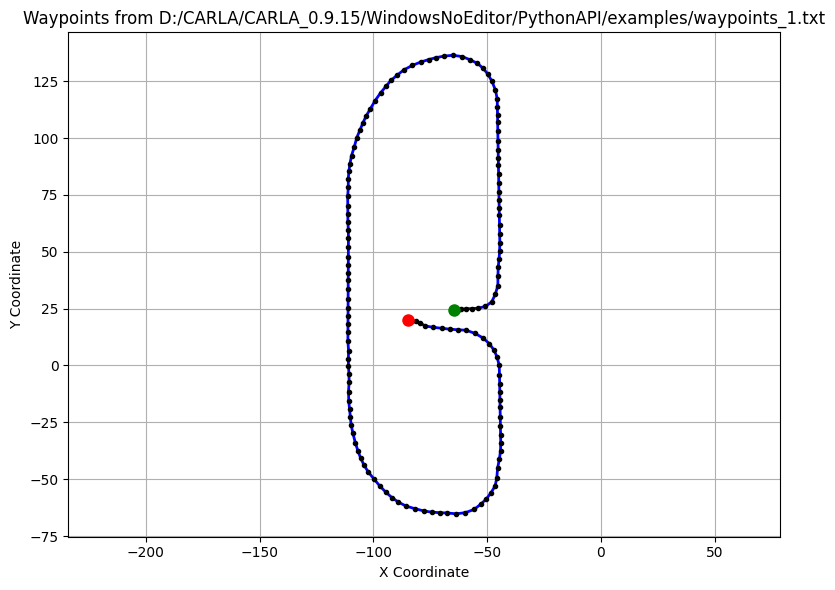

In [11]:
import matplotlib.pyplot as plt
import sys

def plot_waypoints(waypoints_file):
    """Plot the x, y coordinates from waypoints file."""
    # Lists to store coordinates
    x_coords = []
    y_coords = []
    
    # Read the waypoints file
    with open(waypoints_file, 'r') as file:
        # Skip header line
        next(file)
        
        # Process each line
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(',')
                x_coords.append(float(parts[0]))  # x is first column
                y_coords.append(float(parts[1]))  # y is second column
    
    # Create a simple plot
    plt.figure(figsize=(8, 6))
    plt.plot(x_coords, y_coords, 'b-', linewidth=2)  # Blue line for path
    plt.plot(x_coords, y_coords, 'ko', markersize=3)  # Black dots for waypoints
    
    # Mark start and end points
    plt.plot(x_coords[0], y_coords[0], 'go', markersize=8)  # Green dot for start
    plt.plot(x_coords[-1], y_coords[-1], 'ro', markersize=8)  # Red dot for end
    
    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Waypoints from {waypoints_file}')
    plt.grid(True)
    
    # Keep aspect ratio equal
    plt.axis('equal')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Get waypoints file from command line argument, or prompt the user
    if len(sys.argv) > 1:
        waypoints_file = "D:/CARLA/CARLA_0.9.15/WindowsNoEditor/PythonAPI/examples/waypoints_1.txt"
    else:
        waypoints_file = "D:/CARLA/CARLA_0.9.15/WindowsNoEditor/PythonAPI/examples/waypoints_1.txt"
    
    plot_waypoints(waypoints_file)